In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as a3
import LassoHull

In [2]:
##### Methods for Evalution #####
import cvxopt

def project_to_hull(beta, B):
    m = B.shape[1]
    P = cvxopt.matrix(B.T.dot(B))
    q = cvxopt.matrix(-B.T.dot(beta))
    A = cvxopt.matrix(np.ones((1,m)))
    b = cvxopt.matrix(np.array([1.0]))
    G = cvxopt.matrix(-np.identity(m))
    h = cvxopt.matrix(np.zeros(m))
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P,q,A=A,b=b,G=G,h=h)
    ans = np.transpose(np.array(sol['x'])).dot(B.T)
    return ans[0]

def evaluate_hull(C, B):
    dist = []
    for k in range(1, C.shape[1]+1):
        max_dist = 0
        for i in range(B.shape[1]):
            c = project_to_hull(B[:, i], C[:, :k])
            d = np.linalg.norm(B[:, i] - c)
            if d > max_dist:
                max_dist = d
        dist.append(max_dist)
    return dist

def lasso_obj(beta, X, y, rho):
    n = y.size
    res = y - X.dot(beta)
    return 0.5 * res.dot(res) / n + rho * np.linalg.norm(beta, 1)

def find_lasso_boundary(beta, X, y, rho, d, nu, eps=1e-5):
    
    # binary search
    lam_prev = 1.0
    obj_prev = lasso_obj(beta + lam_prev * d, X, y, rho)
    if obj_prev >= nu:
        lam = lam_prev * 0.5
    else:
        lam = lam_prev * 2.0
    while True:
        obj = lasso_obj(beta + lam * d, X, y, rho)
        if obj >= nu:
            lam_prev = lam
            lam *= 0.5
        else:
            lam_prev = lam
            lam *= 2.0
        if (obj >= nu and obj_prev < nu) or (obj_prev >= nu and obj < nu):
            break
    lam_lb = min(lam, lam_prev)
    lam_ub = max(lam, lam_prev)
    while True:
        lam = 0.5 * (lam_lb + lam_ub)
        obj = lasso_obj(beta + lam * d, X, y, rho)
        if obj >= nu:
            lam_ub = lam
        else:
            lam_lb = lam
        if obj <= nu and nu - obj < eps:
            break
    return beta + lam * d

def sample_boundary(beta, X, y, rho, nu, K=100, eps=1e-5, seed=0):
    p = X.shape[1]
    B = []
    for k in range(K):
        np.random.seed(k)
        d = np.random.randn(p)
        d /= np.linalg.norm(d)
        b = find_lasso_boundary(beta, X, y, rho, d, nu, eps=eps)
        B.append(b)
    return B

## Synthetic Data - p=2

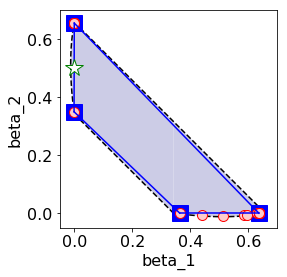

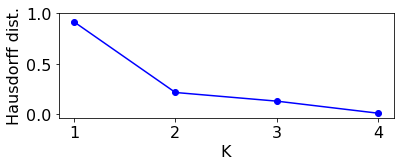

In [3]:
# synthetic data in p=2
X = np.array([[1, 1], [1, 1+1/40]])
y = np.ones(2)
rho = 1.0 / 2

# LassoHull: # of sampling=30, # of vertecies=4
hull = LassoHull.LassoHull(nu=31/30, eta=-1.0, seed=0) # nu = nu^* + 1/40
hull.set_data(X, y, rho)
hull.add_extreme(M=30, verbose=-1)
hull.initialize_hull()
hull.add_vertex(K=3)

# plot B(nu) - fill
fig = plt.figure(figsize=(4, 4))
t = np.linspace(-1 / 80, 0, 200)
plt.fill_between(t, (-np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, (np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, facecolor=[0.8, 0.8, 0.9])
t = np.linspace(0, (10 - np.sqrt(10))/20, 200)
plt.fill_between(t, (-1/np.sqrt(10) - 2 * t + 1) / 2, (1/np.sqrt(10) - 2 * t + 1) / 2, facecolor=[0.8, 0.8, 0.9])
t = np.linspace((10 - np.sqrt(10))/20, (10 + np.sqrt(10))/20, 200)
plt.fill_between(t, (3 - 2 * t - np.sqrt(81 - 40 * t - 40 * np.abs(t)) / np.sqrt(10)) / 2, (1/np.sqrt(10) - 2 * t + 1) / 2, facecolor=[0.8, 0.8, 0.9])

# plot B(nu) - edge
t = np.linspace(0, (10 + np.sqrt(10))/20, 200)
plt.plot(t, (1/np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(0, (10 - np.sqrt(10))/20, 200)
plt.plot(t, (-1/np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(-1 / 80, 0, 200)
plt.plot(t, (np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(-1/ 80, 0, 200)
plt.plot(t, (-np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace((10 - np.sqrt(10)) / 20, (10 + np.sqrt(10)) / 20, 200)
plt.plot(t, (3 - 2 * t - np.sqrt(81 - 40 * t - 40 * np.abs(t)) / np.sqrt(10)) / 2, 'k--')

# plot result
for c in hull.C_.T:
    plt.plot(c[0], c[1], 'bs', markersize=16)
for b in hull.B_:
    plt.plot(b[0], b[1], 'o', markersize=10, markeredgecolor='r', markerfacecolor=[1.0, 0.8, 0.8])
plt.plot(hull.C_[0, [0, 1]], hull.C_[1, [0, 1]], 'b-')
plt.plot(hull.C_[0, [0, 3]], hull.C_[1, [0, 3]], 'b-')
plt.plot(hull.C_[0, [1, 2]], hull.C_[1, [1, 2]], 'b-')
plt.plot(hull.C_[0, [2, 3]], hull.C_[1, [2, 3]], 'b-')
plt.plot(hull.beta_[0], hull.beta_[1], 'g*', markersize=18, markerfacecolor='w')
plt.xlim([-0.05, 0.7])
plt.ylim([-0.05, 0.7])
plt.xlabel('beta_1', fontsize=16)
plt.ylabel('beta_2', fontsize=16)
plt.xticks([0.2*i for i in range(0, 4)], fontsize=16)
plt.yticks([0.2*i for i in range(0, 4)], fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# LassoHull: Psuedo Ground Truth
hullB = LassoHull.LassoHull(nu=31/30, eta=-1.0, seed=0)
hullB.set_data(X, y, rho)
hullB.add_extreme(M=1000, verbose=-1)
dist = evaluate_hull(hull.C_, np.array(hullB.B_).T)

# plot Hausdorff distance
fig = plt.figure()
plt.plot(range(1, len(dist)+1), dist, 'bo-')
plt.xticks(range(1, len(dist)+1), fontsize=16)
plt.yticks([0, 0.5, 1.0], fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('K', fontsize=16)
plt.ylabel('Hausdorff dist.', fontsize=16)
plt.show()

## Synthetic Data - p=3

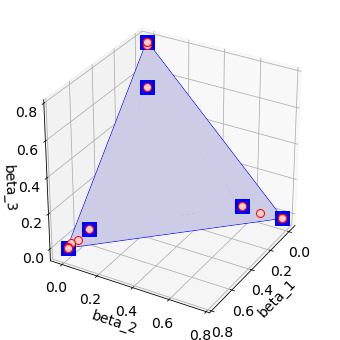

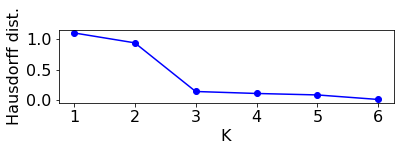

In [4]:
# synthetic data in p=3
X = np.array([[1, 1, 1], [1, 1+1/40, 1], [1, 1, 1+2/40]])
y = np.ones(3)
rho = 1.0 / 3

# LassoHull: # of sampling=50, # of vertecies=6
hull = LassoHull.LassoHull(nu=103/100, eta=-1.0, seed=0) # nu = nu^* + 1/40
hull.set_data(X, y, rho)
hull.add_extreme(M=50, verbose=-1)
hull.initialize_hull()
hull.add_vertex(K=5)

# boundary points
hullB = LassoHull.LassoHull(nu=103/100, eta=-1.0, seed=0) # nu = nu^* + 1/40
hullB.set_data(X, y, rho)
hullB.add_extreme(M=200, verbose=-1)
beta = np.mean(np.array(hullB.B_), axis=0)
C = sample_boundary(beta, X, y, rho, hull.nu * hull.obj_, K=200)
C.extend(hullB.B_)
C = np.array(C)
Q = ConvexHull(C)

# plot result
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
poly = [C[s, :] for s in Q.simplices]
tri = a3.art3d.Poly3DCollection(poly, facecolors=[0.8, 0.8, 0.9], alpha=0.001, linewidths=0)
ax.add_collection3d(tri)
ax.scatter(hull.C_[0, :], hull.C_[1, :], hull.C_[2, :], marker='s', color='b', depthshade=False, s=208)
B = np.array(hull.B_)
ax.scatter(B[:, 0], B[:, 1], B[:, 2], marker='o', color=[1.0, 0.8, 0.8], depthshade=False, s=64, edgecolor='r')
ax.plot(hull.C_[0, [0, 1]], hull.C_[1, [0, 1]], hull.C_[2, [0, 1]], 'b-')
ax.plot(hull.C_[0, [0, 2]], hull.C_[1, [0, 2]], hull.C_[2, [0, 2]], 'b-')
ax.plot(hull.C_[0, [0, 4]], hull.C_[1, [0, 4]], hull.C_[2, [0, 4]], 'b-')
ax.plot(hull.C_[0, [1, 2]], hull.C_[1, [1, 2]], hull.C_[2, [1, 2]], 'b-')
ax.plot(hull.C_[0, [1, 3]], hull.C_[1, [1, 3]], hull.C_[2, [1, 3]], 'b-')
ax.plot(hull.C_[0, [2, 5]], hull.C_[1, [2, 5]], hull.C_[2, [2, 5]], 'b-')
ax.plot(hull.C_[0, [3, 4]], hull.C_[1, [3, 4]], hull.C_[2, [3, 4]], 'b-')
ax.plot(hull.C_[0, [3, 5]], hull.C_[1, [3, 5]], hull.C_[2, [3, 5]], 'b-')
ax.plot(hull.C_[0, [4, 5]], hull.C_[1, [4, 5]], hull.C_[2, [4, 5]], 'b-')
ax.scatter(hull.beta_[0], hull.beta_[1], hull.beta_[2], marker='*', color='w', s=256, depthshade=False, edgecolor='g')
ax.set_xlim(-0.05, 0.8)
ax.set_ylim(-0.05, 0.8)
ax.set_zlim(-0.05, 0.8)
ax.set_xlabel('beta_1', fontsize=14)
ax.set_ylabel('beta_2', fontsize=14)
ax.set_zlabel('beta_3', fontsize=14)
ax.set_xticks([i*0.2 for i in range(0, 5)])
ax.set_xticklabels(['%.1f' % (i*0.2,) for i in range(0, 5)], fontsize=14)
ax.set_yticks([i*0.2 for i in range(0, 5)])
ax.set_yticklabels(['%.1f' % (i*0.2,) for i in range(0, 5)], fontsize=14)
ax.set_zticks([i*0.2 for i in range(0, 5)])
ax.set_zticklabels(['%.1f' % (i*0.2,) for i in range(0, 5)], fontsize=14)
ax.view_init(30, 30)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# LassoHull: Psuedo Ground Truth
hullB = LassoHull.LassoHull(nu=103/100, eta=-1.0, seed=0)
hullB.set_data(X, y, rho)
hullB.add_extreme(M=1000, verbose=-1)
dist = evaluate_hull(hull.C_, np.array(hullB.B_).T)

# plot Hausdorff distance
fig = plt.figure()
plt.plot(range(1, len(dist)+1), dist, 'bo-')
plt.xticks(range(1, len(dist)+1), fontsize=16)
plt.yticks([0, 0.5, 1.0], fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('K', fontsize=16)
plt.ylabel('Hausdorff dist.', fontsize=16)
plt.show()